## <font color=red>NOTICE </font>
### You will start noticing that we are now very light with Markdown cells.
### It remains up to you to create necessary headings, definitions, and any useful info


### BE485/585 Lab 9 - Ex 1
### In this exercise: <br> 
* a) GDAL basics  <br>
* b) Read a Landasat 8/OLI files  <br>
* c) Apply atmospheric correction <br>
 **  histogram analysis
 **  Dark Object Substraction 
* d) Compare RGB, histograms and values  <br> 


In [45]:
# import Libraries
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

import numpy as np
import math
import viplab_lib4 as vip  # New library 
import pandas as pd

#import gdal library
from osgeo import gdal 
import rasterio
from rasterio.plot import show

%matplotlib inline


#### Here is useful user defined function that averages a window in an image
The image shows a window made up of [NxM] pixels<br>
And we are intersted in averaging the signal inside that window

<img src="./Ancillary/Avg_Window_Lab9.jpg" size=10></img>

In [16]:
#custom function to average a slice of a matrix/image 
def pix_avg_win(row,col,wsize,data):

   if(wsize>1):
     psize = wsize//2

     inirow=row-psize
     endrow=row+psize+1
     inicol=col-psize
     endcol=col+psize+1
    
     subset=data[inirow:endrow,inicol:endcol]
     avg = subset.mean()
     #print(subset)
   else:
       avg=data[row,col]
   return avg

### Visualize the data with Rasterio ...Library from above

In [3]:
tiff = rasterio.open("./Data/LC08_L1TP_033037_20200321_20200321_01_RT_sr_band4.tif")
BoundingBox=tiff.bounds
print (BoundingBox)

BoundingBox(left=257685.0, bottom=3553185.0, right=489915.0, top=3789315.0)


### Find and calculate the Image Geographic Extenet

In [14]:
mapInfo_string = str(BoundingBox) #convert to string
#split the strings using the separator comma "," 
mapInfo_split = mapInfo_string.split(",") 
#Extract the upper left-hand corner coordinates from mapInfo
left=mapInfo_split[0].split("=") 
bottom=mapInfo_split[1].split("=") 
right=mapInfo_split[2].split("=") 
top1 = mapInfo_split[3].split("=")
top=top1[1].replace(')', '')
#top=mapInfo_split[3].split("=") 
print('Left:',left[1])
print('bottom:',bottom[1])
print('right:',right[1])
print('top:',top)

xMin = float(left[1]) 
yMax = float(top)
xMax = float(right[1]) 
yMin = float(bottom[1])

#Define extent as a tuple:
Image_ext = (xMin, xMax, yMin, yMax)
print('Image_ext:',Image_ext)
print('Image_ext type:',type(Image_ext))

Left: 257685.0
bottom: 3553185.0
right: 489915.0
top: 3789315.0
Image_ext: (257685.0, 489915.0, 3553185.0, 3789315.0)
Image_ext type: <class 'tuple'>


#### Show the image now

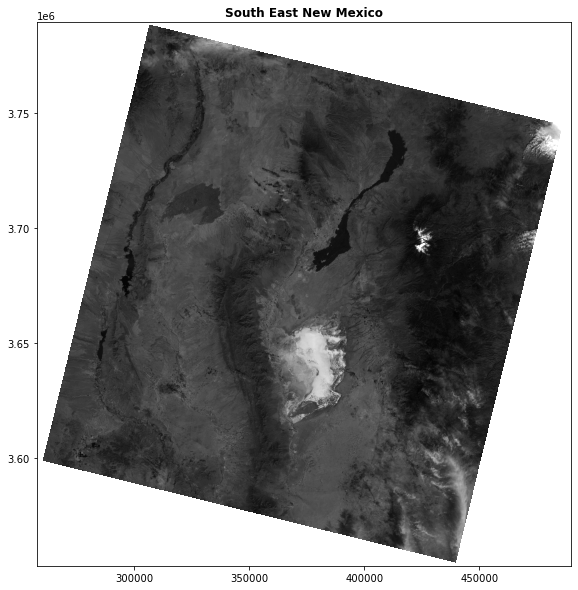

<AxesSubplot:title={'center':'South East New Mexico'}>

In [19]:
#Notice the use of Extent 
plt.figure(figsize=(20,10))
rasterio.plot.show(tiff, extent=Image_ext,title = "South East New Mexico",cmap='gray',vmin=0,vmax=8000)

#### GDAL Basics for GeoTif files
GeoTif and Tiff are tagged files, meaning they contain metadata about the file contents <br>

#### Let us open <font color=blue> a gtif file</font>

In [20]:
#Another way to set default paths
datapath=r'./Data/'
gtif=gdal.Open(datapath+"LC08_L1TP_033037_20200321_20200321_01_RT_sr_band4.tif")

#### <font color="red"> Display info about the file</font>
 This is the power of metadata
 You will recall that we usually had to secify the file size and contents manually 
 But with metadata (embeded info) we can get this info from within the file itself.
 All kinds of info could be stored inside the file in the form of metadata
 Even better if it follows specific structure as in <font color=blue> GeoTif or Tif/Tiff</font>

#### <font color="green"> Lets get some useful info from our TIF file</font>

In [23]:
print("File Information")
#Number of Bands
print("Number of bands:",gtif.RasterCount)

#Dimensions
print("Rows:",gtif.RasterYSize," Columns:",gtif.RasterXSize)

#Reading Geographic Transformation
# topleft X, resolution X, 0, topleft Y, 0, resolution Y (negative value) 
geo=gtif.GetGeoTransform()
print("\ngeotransform:",geo)

#get projection
prj=gtif.GetProjection()
print("\nprojection: ",prj)

File Information
Number of bands: 1
Rows: 7871  Columns: 7741

geotransform: (257685.0, 30.0, 0.0, 3789315.0, 0.0, -30.0)

projection:  PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32613"]]


### * Read a band as raster

In [75]:
#Read band as Raster (first band has index 1)
bandRED=gtif.GetRasterBand(1)

### * Display info about a raster

In [25]:
print("bandRED Info:")

print("NO_DATA_VALUE: ", bandRED.GetNoDataValue())
print("MIN:", bandRED.GetMinimum())
print("MAX", bandRED.GetMaximum())
print("SCALE", bandRED.GetScale())
print("DATATYPE:",gdal.GetDataTypeName(bandRED.DataType))

bandRED Info:
NO_DATA_VALUE:  -9999.0
MIN: -241.0
MAX 12062.0
SCALE None
DATATYPE: Int16


In [28]:
#Another way to get info about the raster data file 
bandRED.GetMetadata()
if bandRED.GetMinimum is None or bandRED.GetMaximum() is None:
    print("\nGDAL thinks this file has no values: ", gtif)
    print("[ MAX ] =", bandRED.GetMaximum())
    print("[ MIN ] =", bandRED.GetMinimum())

if bandRED.GetMinimum() is None or bandRED.GetMaximum() is None:
    bandRED.ComputeStatistics(0)

bandRED.GetMetadata()
if bandRED.GetMinimum is None or bandRED.GetMaximum() is None:
    print("[ MAX ] =", bandRED.GetMaximum())
    print("[ MIN ] =", bandRED.GetMinimum())
else: 
    print("\nIt worked.")
    print("[ MAX ] =", bandRED.GetMaximum())
    print("[ MIN ] =", bandRED.GetMinimum())


It worked.
[ MAX ] = 12062.0
[ MIN ] = -241.0


### * Read a band as NumPy Arrays

Size: (7871, 7741)
MIN: -9999
MAX 12062


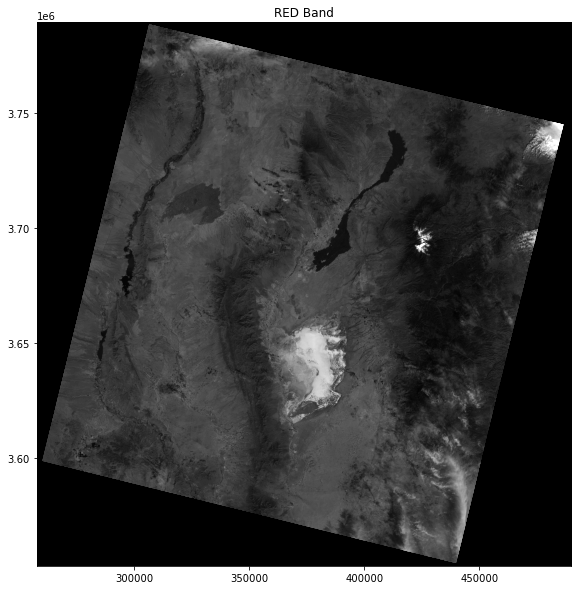

In [76]:
#Read band as Array
dataRED=np.array(gtif.GetRasterBand(1).ReadAsArray())

# Number of rows and columns
print("Size:",dataRED.shape)

print("MIN:", dataRED.min())
print("MAX", dataRED.max())

#Display dataRED
plt.figure(figsize=(10,10))  ## Change the size if you wish
plt.title("RED Band")
plt.imshow(dataRED, extent=Image_ext,cmap='gray',vmin=0,vmax=8000)

### Dispaly the image in  color
### You have all these colors at your disposition, try some of them if you wish
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 
'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 
'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 
'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 
'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 
'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 
'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 
'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 
'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 
'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 
'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 
'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 
'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 
'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 
'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 
'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 
'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 
'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

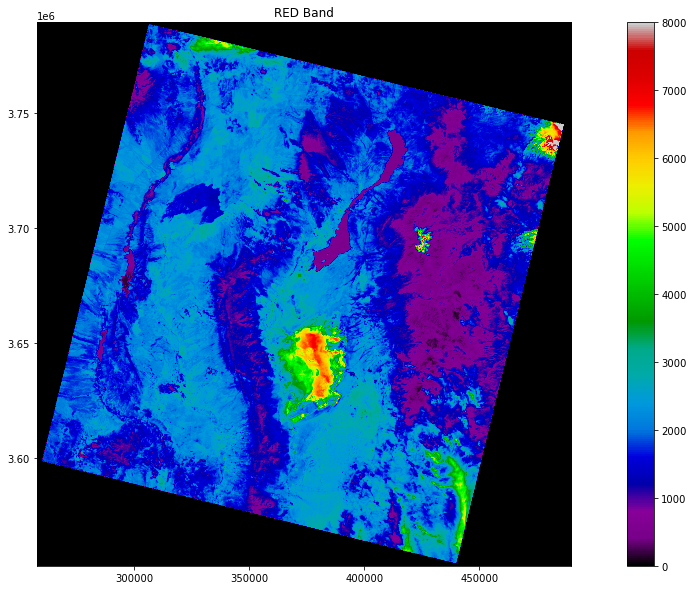

In [77]:
#Display dataRED in color 
plt.figure(figsize=(20,10))
plt.title("RED Band")
plt.imshow(dataRED, extent=Image_ext,cmap='nipy_spectral',vmin=0,vmax=8000)

plt.colorbar()
plt.show()




### * extract a subset from image

In [81]:
# get a subset for faster processing and to avoid NODATA (for now)

dataRED=dataRED[1500:6000,2500:6000]

print("MIN:" , dataRED.min())
print("MAX"  , dataRED.max())

MIN: -139
MAX 12062


# Read Other/additional Bands

In [82]:
#Read NIR band 
dataNIR=gdal.Open(datapath+"LC08_L1TP_033037_20200321_20200321_01_RT_sr_band5.tif").ReadAsArray()
dataNIR=dataNIR[1500:6000,2500:6000]

#Read GREEN band
dataGREEN=gdal.Open(datapath+"LC08_L1TP_033037_20200321_20200321_01_RT_sr_band3.tif").ReadAsArray()
dataGREEN=dataGREEN[1500:6000,2500:6000]

#Read BLUE band
dataBLUE=gdal.Open(datapath+"LC08_L1TP_033037_20200321_20200321_01_RT_sr_band2.tif").ReadAsArray()
dataBLUE=dataBLUE[1500:6000,2500:6000]

# Display bands


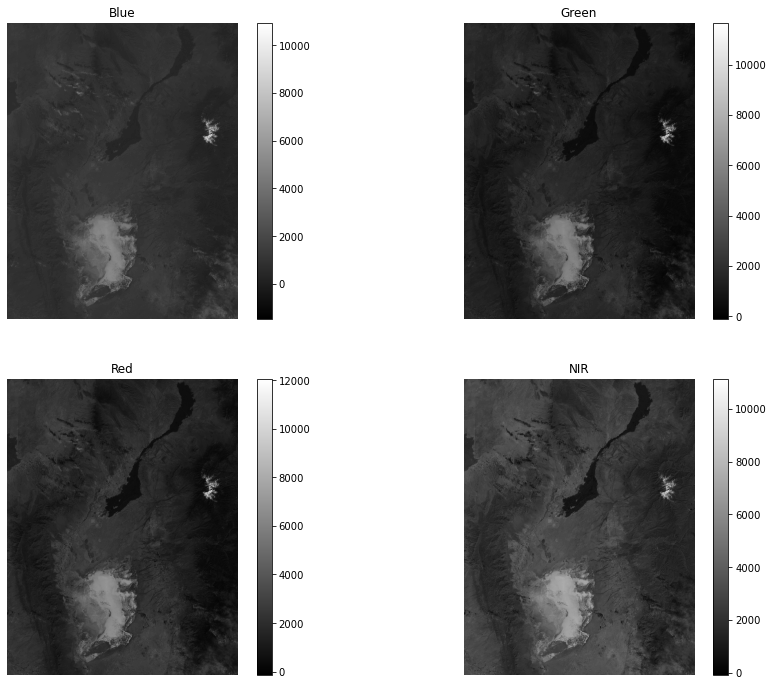

In [83]:
# Display all bands grays scale
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.imshow(dataBLUE, cmap='gray')
plt.title("Blue")
plt.axis('off')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(dataGREEN, cmap='gray')
plt.title("Green")
plt.axis('off')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(dataRED, cmap='gray')
plt.title("Red")
plt.axis('off')
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(dataNIR, cmap='gray')
plt.title("NIR")
plt.axis('off')
plt.colorbar()


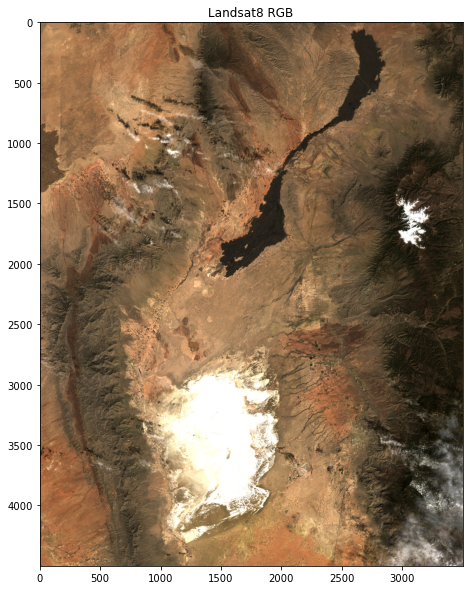

In [85]:
RGBImage=vip.Image_getRGB(dataRED,dataGREEN,dataBLUE,10000,3500)
# Display RGB True color Image
plt.figure(figsize=(20,10))
plt.title('Landsat8 RGB')
plt.imshow(RGBImage)

## Atmospheric Correction: Histogram minimization

Atmospheric Correction: Histogram Minimization
Band Stats:
RED: min= -139  max= 12062  avg= 1871.2228108571428  stdev= 1095.6918725869812
NIR: min= -86  max= 11150  avg= 2622.518443111111  stdev= 1089.592105674111


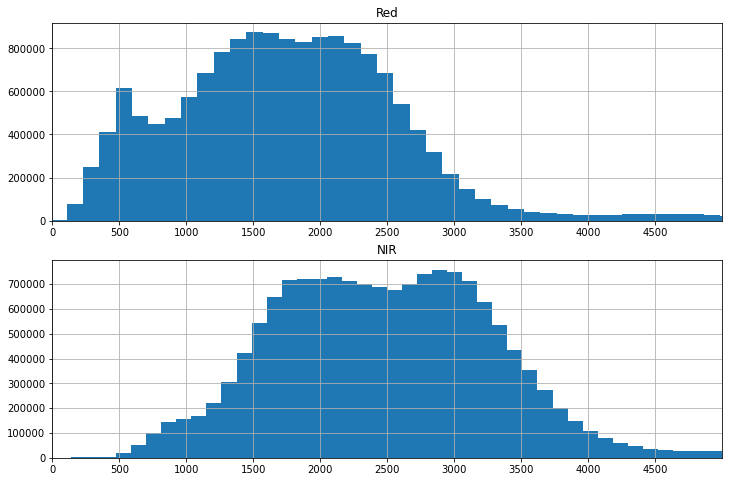

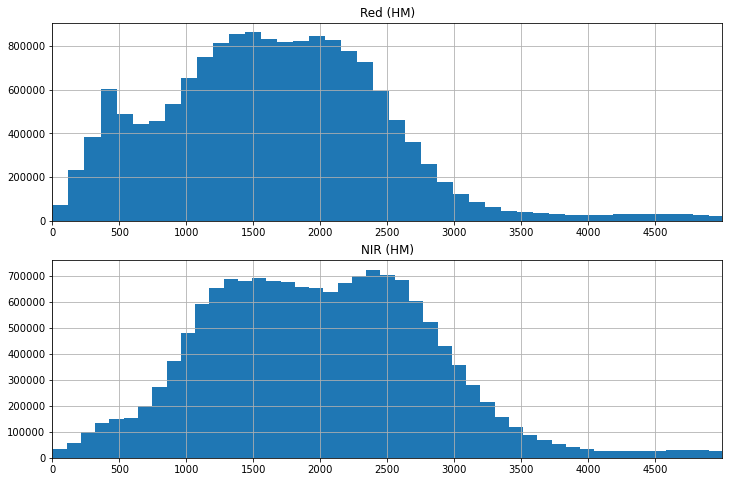

In [86]:
print("Atmospheric Correction: Histogram Minimization")

# display stats about each band (you have to complete GREEN and BLUE bands)
print("Band Stats:")
print("RED: min=",dataRED.min()," max=",dataRED.max()," avg=",dataRED.mean(), " stdev=",dataRED.std())
print("NIR: min=",dataNIR.min()," max=",dataNIR.max()," avg=",dataNIR.mean(), " stdev=",dataNIR.std())


# create histograms
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.hist(dataRED.ravel(), bins=100)
plt.title("Red")
plt.xlim(0,5000)
plt.xticks(np.arange(0,5000,step=500))
plt.grid()

plt.subplot(2,1,2)
plt.hist(dataNIR.ravel(), bins=100)
plt.title("NIR")
plt.xlim(0,5000)
plt.xticks(np.arange(0,5000,step=500))
plt.grid()

# based on the Histogram, set the min value for each band. Do not use the absolute min.
REDMinH=100
NIRMinH=500

# substract histogram min value
dataRED_AC_MHIST=dataRED-REDMinH
dataNIR_AC_MHIST=dataNIR-NIRMinH


#check for negative values. If value<0, set to zero
dataRED_AC_MHIST=np.where(dataRED_AC_MHIST<0, 0, dataRED_AC_MHIST)
dataNIR_AC_MHIST=np.where(dataNIR_AC_MHIST<0, 0, dataNIR_AC_MHIST)

# create histograms for the Corrected datasets
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.hist(dataRED_AC_MHIST.ravel(), bins=100)
plt.title("Red (HM)")
plt.xlim(0,5000)
plt.xticks(np.arange(0,5000,step=500))
plt.grid()

plt.subplot(2,1,2)
plt.hist(dataNIR_AC_MHIST.ravel(), bins=100)
plt.title("NIR (HM)")
plt.xlim(0,5000)
plt.xticks(np.arange(0,5000,step=500))
plt.grid()

## Atmospheric Correction: Dark Object Substraction (DOS)

### * Select an area over water where it is the deepest

Atmospheric Correction: Dark Object Substraction
RED Dark Object avg= 507.854375
NIR Dark Object avg= 763.9482291666667


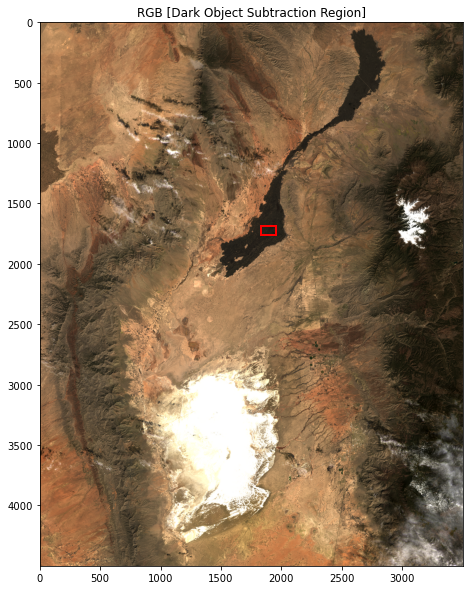

In [87]:
print("Atmospheric Correction: Dark Object Substraction")

# get Dark Object value (average of several pixels)

# using the subset box inside the lake
#rows: 1664 to 1784
#cols: 1813 to 1973

#IniRow=1664
#EndRow=1784
#IniCol=1813
#EndCol=1973

IniRow=1664+20
EndRow=1784-20
IniCol=1813+20
EndCol=1973-20

RED_Dark=np.mean(dataRED[IniRow:EndRow,IniCol:EndCol])
NIR_Dark=np.mean(dataNIR[IniRow:EndRow,IniCol:EndCol])

#display box selection
plt.figure(figsize=(20,10))
plt.title('RGB [Dark Object Subtraction Region]')
plt.imshow(RGBImage)


width=EndCol-IniCol
height=EndRow-IniRow

rectB1=patches.Rectangle((IniCol,IniRow),width,height,linewidth=2,edgecolor='r',facecolor='none')
plt.gca().add_patch(rectB1)


#Display the Dark Object Min Values
print("RED Dark Object avg=",RED_Dark)
print("NIR Dark Object avg=",NIR_Dark)

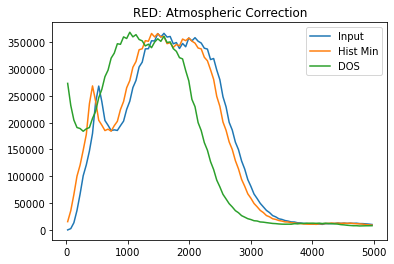

In [88]:

# substract histogram min value
dataRED_AC_DOS=dataRED-RED_Dark
dataNIR_AC_DOS=dataNIR-NIR_Dark


#check for negative values. If value<0, set to zero
dataRED_AC_DOS=np.where(dataRED_AC_DOS<0, -100, dataRED_AC_DOS)
dataNIR_AC_DOS=np.where(dataNIR_AC_DOS<0, -100, dataNIR_AC_DOS)


# Prepare histograms for RED band: To plot all together
hist,center,width=vip.histo_prepare(dataRED,100,[0,5000])
hist2,center2,width=vip.histo_prepare(dataRED_AC_MHIST,100,[0,5000])
hist3,center3,width=vip.histo_prepare(dataRED_AC_DOS,100,[0,5000])
plt.figure()
plt.plot(center,hist,label='Input')
plt.plot(center2,hist2,label='Hist Min')
plt.plot(center3,hist3,label='DOS')
plt.title('RED: Atmospheric Correction')
plt.legend()

Display Corrected RED Bands


(-0.5, 3499.5, 4499.5, -0.5)

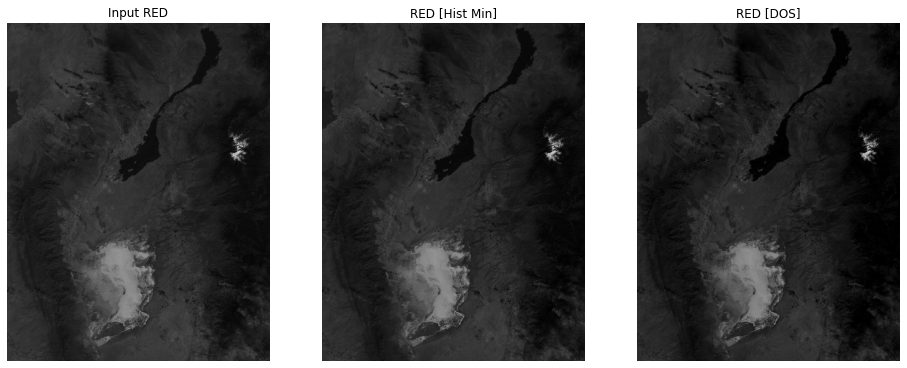

In [89]:
print("Display Corrected RED Bands")

# Display all bands grays scale
plt.figure(figsize=(16,24))

plt.subplot(1,3,1)
plt.imshow(dataRED, cmap='gray')
plt.title("Input RED")
plt.axis('off')
#plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(dataRED_AC_MHIST, cmap='gray')
plt.title("RED [Hist Min]")
plt.axis('off')
#plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(dataRED_AC_DOS, cmap='gray')
plt.title("RED [DOS]")
plt.axis('off')
#plt.colorbar()


## Spectral signatures for Objects

In [90]:
#different pixel windows
pwindow=[1,3,5,9,11,15]
nsize=len(pwindow)

print("Extracting for white Sand")

#White Sands pixel
row=3114
col=1490

#create array to hold values
data=np.zeros((nsize,3))
#extract values at each window size for the bands
for i in range(nsize):
    data[i,0]=pix_avg_win(row,col,pwindow[i],dataRED)
    data[i,1]=pix_avg_win(row,col,pwindow[i],dataNIR)
    data[i,2]=pix_avg_win(row,col,pwindow[i],dataBLUE)
   

#create panda's frame
df2 = pd.DataFrame(data,index=pwindow, columns=['red','nir','blue'])

#display fram
df2



Extracting for white Sand


,red,nir,blue
1,6898.000000,7408.000000,5033.000000
3,6645.222222,7139.333333,4928.666667
5,6715.880000,7231.720000,4970.400000
9,6733.135802,7246.518519,4978.814815
11,6752.809917,7265.157025,4989.727273
15,6780.800000,7292.684444,5014.222222


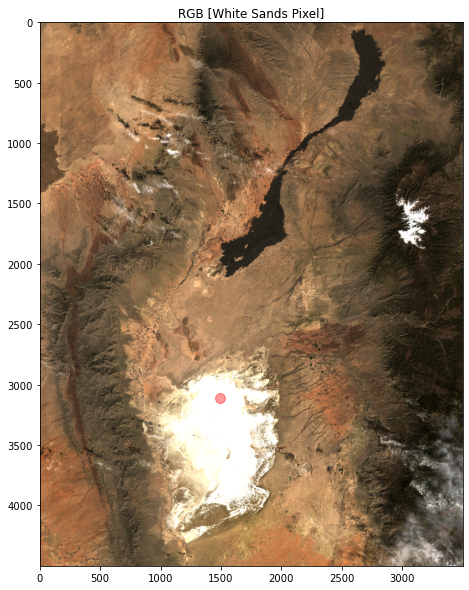

In [91]:
#display box selection
plt.figure(figsize=(20,10))
plt.title('RGB [White Sands Pixel]')
plt.imshow(RGBImage)

plt.plot(col,row,marker='o',markersize='10', color='red',alpha=0.4)

#### <font color=red>To Do</font>
 1. Create histograms for input bands: Green, Blue and MIR
 2. Complete the atmospheric correction (both methods) for each band: Green, Blue and MIR
 3. For bands NIR, Green, Blue and MIR complete histograms similar to the presented example for RED

In [ ]:
# Your work/ode here 